<a href="https://colab.research.google.com/github/maximecharriere/movie-chatbot/blob/master/movie-chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chatbot cinéphile - WELCOME**
*Par Dylan **Morocutti** et Maxime **Charrière**.*

# Libraries importation

In [2]:
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False


import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import treebank, nps_chat
from nltk.cluster import KMeansClusterer
import pandas as pd
import gensim
from gensim.models import Word2Vec
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn import metrics
import spacy

nlp = spacy.load("en_core_web_sm")

print("Libraries version:")
print(f"Numpy:      {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"NLTK:       {nltk.__version__}")
print(f"Pandas:     {pd.__version__}")
print(f"Gensim:     {gensim.__version__}")
print(f"Sklearn:    {sklearn.__version__}")
print(f"Spacy:      {spacy.__version__}")

Libraries version:
Numpy:      1.18.4
Matplotlib: 3.2.1
Tensorflow: 2.2.0
NLTK:       3.2.5
Pandas:     1.0.4
Gensim:     3.6.0
Sklearn:    0.22.2.post1
Spacy:      2.2.4


## Data preparation

In [10]:
## Data importation
if IN_COLAB :
    url_movie_wiki = "https://raw.githubusercontent.com/maximecharriere/movie-chatbot/master/data/movie_wiki_infos/wiki_movie_plots_deduped.csv"
else:
    url_movie_wiki = "data/movie_wiki_infos/wiki_movie_plots_deduped.csv"
    
movies = pd.read_csv(url_movie_wiki, sep=',', engine='python')[['Title','Plot','Genre']]
movies.head(20)

,Title,Plot,Genre
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr...",unknown
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov...",unknown
2,The Martyred Presidents,"The film, just over a minute long, is composed...",unknown
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...,unknown
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...,unknown
5,Alice in Wonderland,"Alice follows a large white rabbit down a ""Rab...",unknown
6,The Great Train Robbery,The film opens with two bandits breaking into ...,western
7,The Suburbanite,The film is about a family who move to the sub...,comedy
8,The Little Train Robbery,The opening scene shows the interior of the ro...,unknown
9,The Night Before Christmas,Scenes are introduced using lines of the poem....,unknown


In [11]:
print(f"Nombre de catégories: {len(movies['Genre'].value_counts())}")

Nombre de catégories: 2265


In [12]:
## Manual harmonization of categories

movies['GenreCorrected']=movies['Genre'] 
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('/', ' ')

# Delete unwanted categories
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('unknown', '')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[not in citation given\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('avant-garde','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('period','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('national','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('board','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('costume','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movie','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('films','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('film','')

# Rename categories
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-pic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biopic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographical', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biodrama', 'biography drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-drama', 'biography drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animated','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anime','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('disaster','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedey','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramedy','comedy drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('mockumentary','documentary')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historical','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historic','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('prehistoric','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('mythology','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romantic','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3-d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci-fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ttriller','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science fiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung-fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial arts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bruceploitation','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('stop-motion','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming of age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming-of-age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama about child soldiers','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('melodrama','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv miniseries','serial')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('television miniseries','serial')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("war-time","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wartime","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war ii','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war i','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("tokusatsu","action")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("ww1","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wwii","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroes','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroe','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familydrama','family drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('famil ','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('espionage','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('noir','black')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dark','black')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psychological','psycho')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom-com','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gun fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('docudrama','documentary drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('football','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial art','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotica','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotic','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musical','music')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gangster','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('swashbuckler','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('police','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dance','sport')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sports','sport')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('muslim','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('propaganda','political')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('samurai','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sexploitation','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('homosexual','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('socio','social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sexual','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sex','adult')

# Merge some categories
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('family','child')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial_arts','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horror','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('war','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventure','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fiction','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superhero','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspense','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('thriller','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('epic','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('crime','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('music','cultural')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sport','cultural')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography','cultural')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('history','cultural')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('documentary','cultural')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('political','cultural')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science','cultural')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psycho','cultural')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('mystery','thriller')


print(f"Nombre de catégories: {len(movies['GenreCorrected'].value_counts())}")

Nombre de catégories: 1411


In [13]:
## Automatic harmonization of categories and listing of them

nlp = spacy.load("en_core_web_sm")

movies['GenreListed'] = movies['GenreCorrected']

for genre in movies['GenreCorrected'].unique():
  tokens = nlp(genre)
  listed_genre = [token.lemma_.lower() for token in tokens if not token.is_punct and not token.is_digit and not token.is_space and not token.is_stop]
  for i in np.where(movies['GenreCorrected']==genre)[0]:
    movies.at[i,'GenreListed'] = np.unique(np.array(listed_genre))

movies.head(20)

,Title,Plot,Genre,GenreCorrected,GenreListed
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr...",unknown,,[]
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov...",unknown,,[]
2,The Martyred Presidents,"The film, just over a minute long, is composed...",unknown,,[]
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...,unknown,,[]
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...,unknown,,[]
5,Alice in Wonderland,"Alice follows a large white rabbit down a ""Rab...",unknown,,[]
6,The Great Train Robbery,The film opens with two bandits breaking into ...,western,action,[action]
7,The Suburbanite,The film is about a family who move to the sub...,comedy,comedy,[comedy]
8,The Little Train Robbery,The opening scene shows the interior of the ro...,unknown,,[]
9,The Night Before Christmas,Scenes are introduced using lines of the poem....,unknown,,[]


In [0]:
# Saving of all film
movies[['Title','Genre','GenreCorrected','GenreListed']].to_csv('completGenres.csv')

if IN_COLAB:
    files.download('completGenres.csv') 

In [0]:
## Listing of all unique categories and their occurrence
genres_array = np.array([])
for genre in movies['GenreListed']:
    genres_array = np.concatenate((genres_array, genre ))
uniqueGenre, uniqueGenreCount = np.unique(genres_array, return_counts=True)
print(f"Nombre de catégories: {len(uniqueGenre)}")

In [16]:
# Saving of unique categories
genres = pd.DataFrame({'Genre':uniqueGenre, 'Count':uniqueGenreCount}).sort_values(by=['Count'], ascending = False, ignore_index=True)
genres.to_csv('uniqueGenres.csv')

if IN_COLAB:
    files.download('uniqueGenres.csv') 

Nombre de catégories: 559


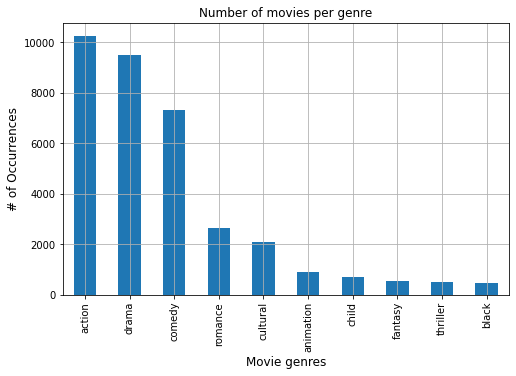

In [17]:
## Show 10 main categories
mainGenres = genres.loc[:9,:]
mainGenres.plot(x='Genre', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per genre")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

In [18]:
## Keep only the main categories
movies['MainGenre'] = movies['GenreListed'].apply(lambda x: x[np.in1d(x,mainGenres)])

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [19]:
## Keep only films with categories
print(movies.shape)
selectedMovies = movies[movies['MainGenre'].apply(len)>0]
print(selectedMovies.shape)

(34886, 6)
(28130, 6)


In [30]:
# Creat the output layer with all categories
%store -r categoriesVector
try:
  categoriesVector
except:
  categoriesVector = np.stack(selectedMovies['MainGenre'].apply(lambda x: np.isin(mainGenres['Genre'],x))*1)
  %store categoriesVector

CPU times: user 852 ms, sys: 11 ms, total: 863 ms
Wall time: 864 ms


In [0]:
np.savetxt('categoriesVector.csv', categoriesVector, delimiter=',')

if IN_COLAB:
    files.download('categoriesVector.csv') 

## Splitting The Data into Training and Test Sets

In [0]:
rawPlot_train, rawPlot_test, cat_train, cat_test = train_test_split(selectedMovies['Plot'], categoriesVector, train_size=0.8, shuffle=True) #80% 20%

In [77]:
type(rawPlot_test)

pandas.core.series.Series

## Plot preparation

In [0]:
def plotTokenizer(plot):
  tokens = nlp(plot)
  return [token.lemma_.lower() for token in tokens if not token.is_punct and not token.is_digit and not token.is_space and not token.is_stop]

In [27]:
plotVectorizer  = TfidfVectorizer(tokenizer = plotTokenizer, min_df=3, max_features=10000)

CPU times: user 57 µs, sys: 0 ns, total: 57 µs
Wall time: 73.4 µs


In [29]:
%%time
# Learn vocabulary from training texts and vectorize training texts.
%store -r plot_train
try:
  plot_train
except:
  plot_train = plotVectorizer.fit_transform(rawPlot_train)
  %store plot_train

CPU times: user 25min 30s, sys: 14.1 s, total: 25min 44s
Wall time: 25min 45s


In [32]:
%%time
# Vectorize validation texts.
plot_test = plotVectorizer.transform(rawPlot_test)

%store -r plot_test
try:
  plot_test
except:
  plot_test = plotVectorizer.transform(rawPlot_test)
  %store plot_test

CPU times: user 6min 15s, sys: 3.13 s, total: 6min 18s
Wall time: 6min 18s


In [34]:
np.savetxt('plot_train.csv', plot_train.toarray(), delimiter=',')
np.savetxt('plot_test.csv', plot_test.toarray(), delimiter=',')

if IN_COLAB:
  files.download('plot_train.csv') 
  files.download('plot_test.csv') 

ValueError: ignored

# Naive Bayes Classification

In [78]:
cat_train.drama

AttributeError: ignored

In [0]:
multinomialNB=OneVsRestClassifier(MultinomialNB())
multinomialNB.fit(plot_train, cat_train.action)